In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from pymc_marketing.customer_choice.mixed_logit import MixedLogit
from pymc_marketing.paths import data_dir

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.12/site-packages/pymc_marketing/pytensor_utils.py:34: FutureWarning: `pytensor.graph.basic.ancestors` was moved to `pytensor.graph.traversal.ancestors`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import ancestors
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.12/site-packages/pymc_marketing/mmm/multidimensional.py:216: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.12/site-packages/pymc_marketing/mmm/time_slice_cross_validation.py:32: UserWarning: The pymc_marketing.mmm.builders module is experimental and its API may change without warning.
  from pymc_marketing.mmm.builders

In [2]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

# Mixed Logit (Random Coefficients Logit)

The **Mixed Logit model** extends the Multinomial Logit (MNL) by allowing **random coefficients on alternative-specific covariates**, while maintaining fixed population-level effects for individual-specific covariates. It improves on the limitations of MNL by capturing unobserved preference heterogeneity across individuals, but doesn't require the imposition of market structure assumptions as in Nested Logit models. 

This implementation additionally supports a **control function approach to endogeneity**, allowing potentially endogenous alternative-specific regressors (e.g. price) to be included in a structurally interpretable way.

A defining feature of the model is the explicit decomposition of utility into:

1. **Alternative-specific covariates**
2. **Individual-specific covariates**
3. **Random effects on alternative-specific covariates**
4. **Control function terms correcting for endogeneity**

The central idea of Mixed Logit discrete choice models is, as with Nested Logit and Multinomial choice models, to represent an individual's subjective utility for any good in a marketplace as a function of the observable attributes of that good, while allowing for how individual circumstance and market forces can shift or alter that utility calculation. 


#### Utility Decomposition with Random Effects and Endogeneity Correction
In the decomposition of the utility metric, we let individual  

$n = 1, \ldots, N $  
choose among alternatives  
$ j = 1, \ldots, J $
at choice occasion  
$t = 1, \ldots, T_n $.

The latent utility for alternative \( j \) is

$$
U_{njt}
=
\underbrace{
\boldsymbol{\alpha}
}_{\text{alt-specific fixed effects}}
+
\underbrace{
\mathbf{x}_{njt}^\top \boldsymbol{\beta}_n
}_{\text{alt-specific random effects}}
+
\underbrace{
\mathbf{z}_{n}^\top \boldsymbol{\gamma}_j
}_{\text{individual-specific effects}}
+
\overbrace{
\underbrace{
\mathbf{r}_{njt}^\top \boldsymbol{\lambda_{cf}}
}_{\text{control function}}
}^{\text{optional endogeneity correction}}
+
\varepsilon_{njt}
$$

where:

- $\mathbf{x}_{njt}$: alternative-specific covariates  
- $\boldsymbol{\beta}_n$: individual-specific random coefficients  
- $\boldsymbol{\alpha} $: fixed coefficients on alternative-specific covariates  
- $\mathbf{z}_n$: alternative-specific covariates  
- $\boldsymbol{\gamma}_j$: individual-specific coefficients on $ \mathbf{z}_n $  
- $\mathbf{r}_{njt}$: control function residuals  
- $\boldsymbol{\lambda_{cf}}$: control function coefficients  
- $\varepsilon_{njt} \sim \text{i.i.d. EV}_1$


#### Motivation: Control Function for Endogeneity

Alternative-specific variables such as **price** may be endogenous due to correlation with unobserved components of utility. Direct inclusion of such variables can bias estimates of both fixed and random coefficients.

The control function approach addresses this by:

1. Modeling the endogenous regressor in a first-stage equation
2. Including the resulting residual in the utility function

#### First-Stage Model

Let $p_{njt}$ denote an endogenous alternative-specific regressor (e.g. price). The first-stage model is

$$
p_{njt}
=
\mathbf{q}_{njt}^\top \boldsymbol{\pi}
+
r_{njt}
$$

where:

- $\mathbf{q}_{njt}$ includes instruments and exogenous controls
- $r_{njt}$ is the first-stage residual

The estimated residual

$$
\hat{r}_{njt}
$$

is carried forward into the choice model.

#### Second-Stage Utility Adjustment

The residual enters utility linearly as a control function:

$$
U_{njt}
=
\cdots
+
\lambda_{cf} \, \hat{r}_{njt}
+
\varepsilon_{njt}
$$

A statistically significant $\lambda_{cf}$ indicates endogeneity in the original regressor.

This approach preserves the structural interpretation of the utility coefficients while correcting for bias.

#### Random Effects Specification

The mixed logit model implements **random effects through a hierarchical (multilevel) structure**, in which individual-specific coefficients are treated as draws from a common population-level distribution.

For each individual \( n \) and each random coefficient \( k \), the preference parameter is modeled as

$$
\beta_{n,k} \sim \mathcal{N}(\mu_k, \sigma_k^2)
$$

The key features of this specification are:

- **Independence across coefficients**  
  Each random coefficient is assumed to be independent of the others. The joint distribution of the random effects has a diagonal covariance structure.

- **Hierarchical pooling across individuals**  
  Although coefficients are independent across dimensions, they are *not* estimated independently for each individual. Instead, all individual-level coefficients are linked through shared population-level parameters $\mu_k$ and $\sigma_k$.

- **Partial pooling**  
  Individual-level estimates borrow strength from the population distribution. Individuals with limited data are shrunk more strongly toward the population mean, while individuals with richer choice histories exhibit greater dispersion.

This hierarchical structure allows the model to capture systematic preference heterogeneity while remaining computationally tractable and avoiding the complexity of estimating full covariance matrices.

Importantly, while the random coefficients are independent *a priori*, they may exhibit **posterior dependence** induced by the data and the structure of the utility function.


### Random Effects vs. Endogeneity Control: A Modeling Trade-off

The mixed logit model combines two powerful mechanisms for explaining variation in observed choices: random coefficients and control functions for endogeneity. While both address sources of unexplained variation in utility, they do so in fundamentally different ways, and understanding the trade-off between them is essential for sound model specification and interpretation.

Random effects explain variation by imposing structure on preferences. By allowing coefficients on alternative-specific attributes—such as price—to vary across individuals, the model attributes persistent differences in behavior to latent taste heterogeneity. In effect, unexplained dispersion in choice behavior is absorbed by assuming that individuals systematically value attributes differently, and that these preferences are stable across repeated choice occasions. This is a structural explanation: variation is interpreted as reflecting genuine differences in preferences.

The control function approach addresses a different source of variation: endogeneity arising from correlation between observed attributes and unobserved utility components. In many choice settings, prices are not set exogenously. They may reflect unobserved product quality, local market conditions, or strategic pricing responses that are also relevant to consumers’ utility. In this case, variation in choices driven by these unobservables should not be attributed to preference heterogeneity. Instead, the control function explicitly removes the component of the endogenous regressor that is correlated with the unobserved utility shock, reallocating that variation away from the structural preference parameters.

When both mechanisms are present, there is an important tension. Random effects are flexible and can “explain away” substantial variation in choices, even when that variation is in fact driven by endogeneity. If prices are endogenous and no control function is included, the model may incorrectly interpret systematic price–utility correlation as evidence of heterogeneous price sensitivity. Conversely, a strong control function can substantially reduce the residual variation attributed to random coefficients, leading to smaller estimated heterogeneity.

The strength and provenance of the pricing instrument therefore play a central role in how variance is partitioned. A weak or poorly motivated instrument may fail to isolate the endogenous component of price variation, leaving the random effects to absorb both true preference heterogeneity and spurious correlation. A strong instrument—one that shifts prices for reasons plausibly orthogonal to consumer utility—allows the control function to explain the appropriate portion of variance, leaving the random coefficients to capture genuine differences in tastes.

From a modeling perspective, this means that random effects and endogeneity controls should not be viewed as substitutes, but as complementary tools with distinct interpretive roles. Random effects encode structural assumptions about preference heterogeneity; control functions encode identifying assumptions about the data-generating process for endogenous regressors. Careful instrument selection and transparent justification are therefore critical, as they directly determine how variation in observed choices is attributed—either to latent preferences or to market-level forces operating outside the utility specification.

In applied work, examining how the estimated heterogeneity changes with and without the control function can be informative. Large shifts in the variance of random coefficients after introducing a valid instrument often signal that what initially appeared to be taste heterogeneity was, in fact, driven by endogeneity.


### Travel Choice Example
Let's first look at an example of how to implement a Mixed Logit model with out endogeneity correction using PyMC-Marketing. We will use a travel choice dataset that contains information on individuals' choices among different modes of transportation (car, bus, train, air) along with various attributes of each mode.




In [3]:
data_path = data_dir / "TravelMode_wide.csv"
df = pd.read_csv(data_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   individual    210 non-null    int64 
 1   wait_air      210 non-null    int64 
 2   wait_bus      210 non-null    int64 
 3   wait_car      210 non-null    int64 
 4   wait_train    210 non-null    int64 
 5   vcost_air     210 non-null    int64 
 6   vcost_bus     210 non-null    int64 
 7   vcost_car     210 non-null    int64 
 8   vcost_train   210 non-null    int64 
 9   travel_air    210 non-null    int64 
 10  travel_bus    210 non-null    int64 
 11  travel_car    210 non-null    int64 
 12  travel_train  210 non-null    int64 
 13  gcost_air     210 non-null    int64 
 14  gcost_bus     210 non-null    int64 
 15  gcost_car     210 non-null    int64 
 16  gcost_train   210 non-null    int64 
 17  mode          210 non-null    object
 18  income        210 non-null    int64 
 19  size    

In [4]:
utility_eqs = [
    "car ~ wait_car + vcost_car + travel_car | income |  wait_car",
    "bus ~ wait_bus + vcost_bus + travel_bus | income |  wait_bus",
    "train ~ wait_train + vcost_train + travel_train | income | wait_train",
    "air ~ wait_air + vcost_air + travel_air | income |  wait_air",
]
mxl = MixedLogit(
    df,
    utility_eqs,
    depvar="mode",
    covariates=["wait", "vcost", "travel"],
)

mxl

The above code block specifies and initializes a mixed logit model for a transportation mode choice problem with four alternatives: **car**, **bus**, **train**, and **air**. Each string in utility_eqs defines the utility for one transportation mode relative to the baseline alternative. The choice set consists of four mutually exclusive alternatives, and the observed choice is stored in the mode column of the data frame. The baseline alternative is implicitly defined as the last alternative in the list (in this case, "air").

**Alternative-Specific Covariates**

The left-hand side of each formula includes alternative-specific attributes:

 - wait_*: waiting time

 - vcost_*: variable cost

 - travel_*: in-vehicle travel time

These variables vary across alternatives and choice occasions and enter utility with fixed population-level coefficients by default.

**Individual-Specific Covariates**

The middle component of the formula (| income |) specifies income as an individual-specific covariate. Income does not vary across alternatives but shifts the relative utility of each mode through alternative-specific coefficients. This allows income to affect, for example, the attractiveness of air travel differently than car or bus.

**Random Effects on Alternative-Specific Covariates**

The right-hand side of the formula specifies wait_* as a random coefficient. This means that sensitivity to waiting time is allowed to vary across individuals:
The random effect applies only to the alternative-specific waiting-time variables and is constant across all choice occasions for a given individual. Other alternative-specific covariates (vcost_* and travel_*) are treated as fixed effects.


In [5]:
mxl.sample(
    fit_kwargs={
        "target_accept": 0.95,
        "tune": 2000,
        "draws": 5000,
        "chains": 4,
        "cores": 4,
        "nuts_sampler": "numpyro",
    }
)

Sampling: [alphas_, betas_fixed_, betas_non_random, likelihood, mu_random, sigma_random, z_random]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [likelihood]


Output()

**The Model Graph**

We can visualize the model structure using Graphviz to see how the components relate to each other:

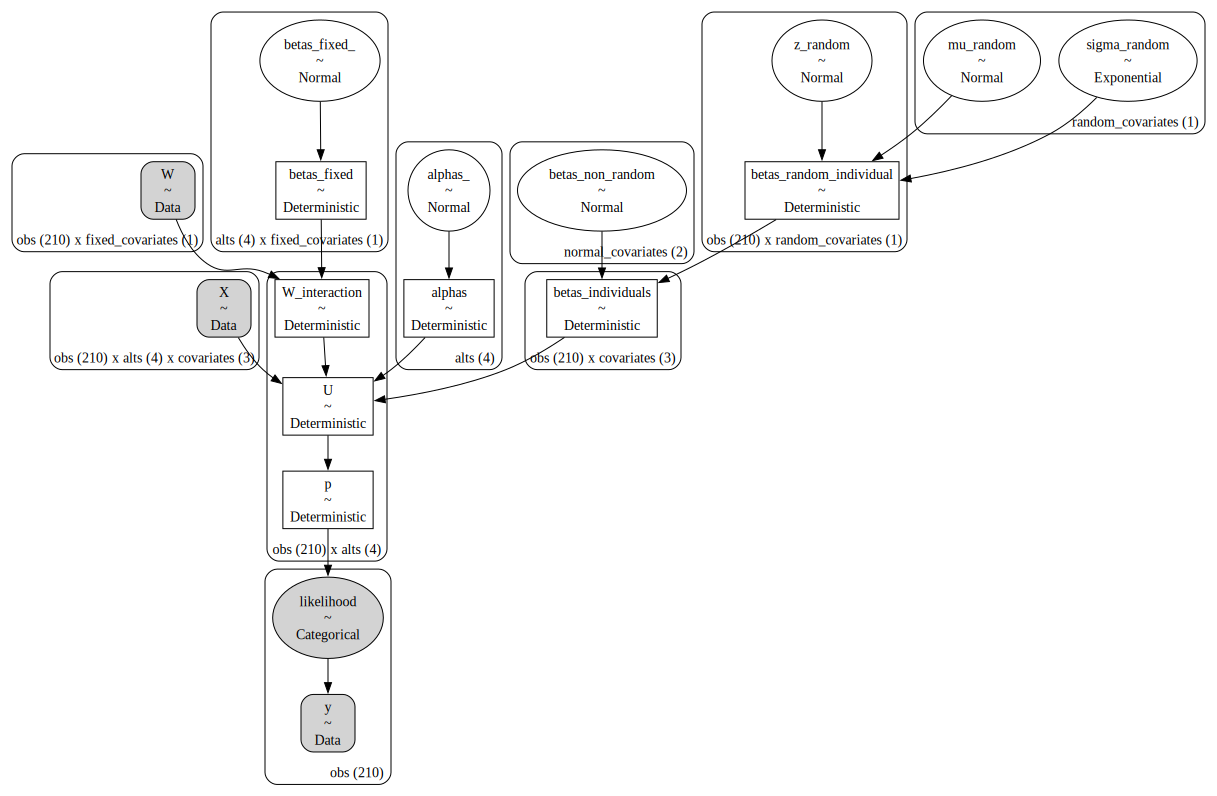

In [6]:
pm.model_to_graphviz(mxl.model)

This table summarizes posterior estimates from a mixed logit model with alternative-specific intercepts (alphas), fixed coefficients on alternative-specific covariates (betas_non_random) and the hierarchical random coefficients on waiting time (mu_random, sigma_random).

In [7]:
az.summary(
    mxl.idata, var_names=["alphas_", "betas_non_random", "mu_random", "sigma_random"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alphas_[car],-8.127,2.184,-12.232,-4.148,0.058,0.038,1498.0,1991.0,1.0
alphas_[bus],1.452,1.371,-1.128,4.044,0.033,0.020,1745.0,2614.0,1.0
alphas_[train],3.455,1.326,1.024,5.939,0.034,0.021,1556.0,2081.0,1.0
alphas_[air],-0.067,4.871,-9.056,9.324,0.060,0.086,6570.0,2725.0,1.0
betas_non_random[vcost],-0.007,0.012,-0.029,0.015,0.000,0.000,3411.0,3036.0,1.0
betas_non_random[travel],-0.007,0.002,-0.011,-0.004,0.000,0.000,2064.0,2517.0,1.0
mu_random[wait],-0.207,0.040,-0.284,-0.141,0.001,0.001,857.0,1563.0,1.0
sigma_random[wait],0.125,0.035,0.067,0.193,0.001,0.001,670.0,1360.0,1.0


For example if we see `alphas_[car]` implies a strongly negative mean (−8.18) with a tight credible interval well below zero, which imples that after accounting for wait time, travel time, cost, and income, car is substantially less preferred relative to the baseline. While `betas_non_random_[vcost]` shows a negative mean (−0.007), indicating that higher variable costs decrease utility across all individuals on average, as expected. While the random coefficient on wait time (`mu_random_[wait]` and `sigma_random_[wait]`) indicates that, on average, individuals dislike longer wait times (mean of −0.208), there is considerable heterogeneity in this preference (standard deviation of 0.12), suggesting that some individuals are much more sensitive to wait times than others. The model samples well and effects seem well identified.

High level, this suggests that train is structurally preferred while car is strongly disfavored, and wait time is an important driver of choice with meaningful individual differences.

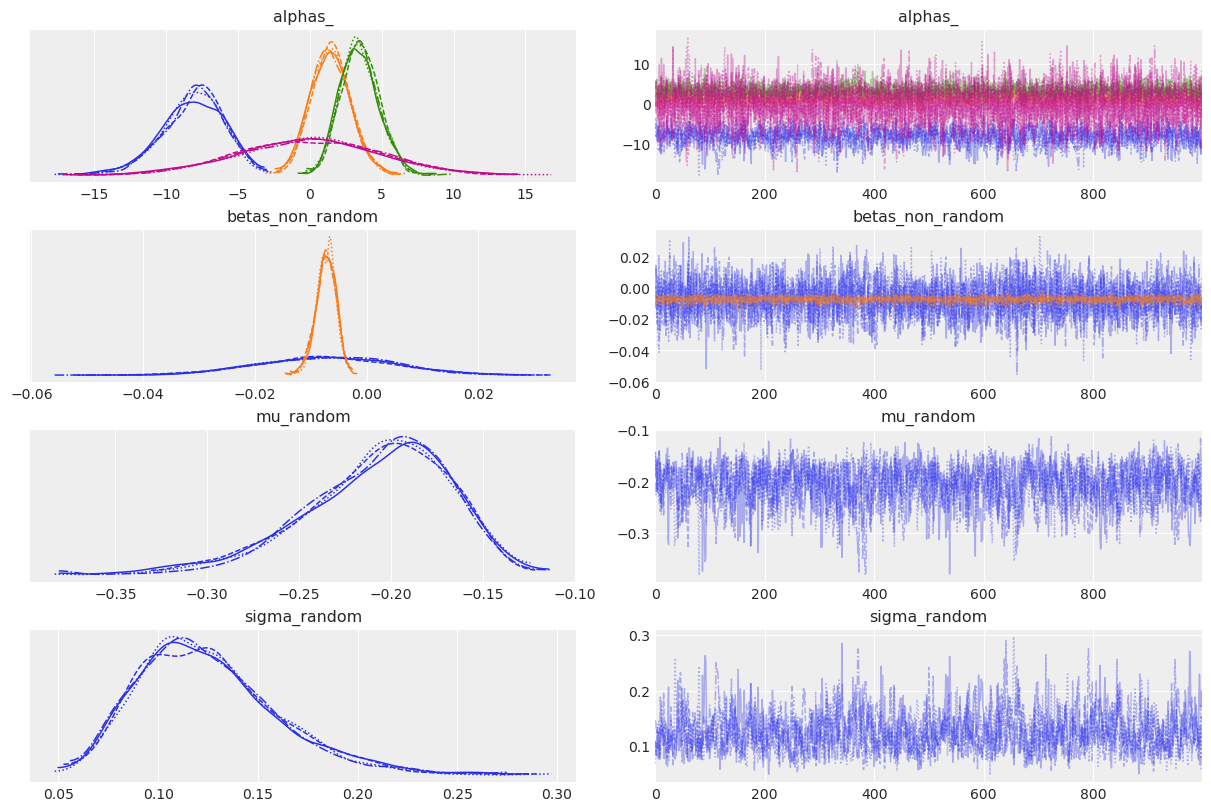

In [8]:
az.plot_trace(
    mxl.idata, var_names=["alphas_", "betas_non_random", "mu_random", "sigma_random"]
);

The combination of a negative mean and a nontrivial standard deviation implies that aiting time is a key driver of choice, average disutility is strong and individual differences matter meaningfully. 

### Counterfactual Analysis
We can use the fitted mixed logit model to perform counterfactual analysis by simulating changes in choice probabilities under different scenarios. For example, we can analyze how reducing wait times for bus and train while increasing wait time for air travel affects market shares. Similar to the MNL and Nested Logit examples, we first create a new dataset reflecting the policy change, then use the model to predict choice probabilities under this new scenario. Let's simulate a scenario where wait times for bus and train are halved, while wait time for air travel is increased by 50%. 

In [9]:
### Counterfactual Imputations
new_df = df.copy()
new_df["wait_bus"] = new_df["wait_bus"] * 0.5
new_df["wait_train"] = new_df["wait_train"] * 0.5
new_df["wait_air"] = new_df["wait_air"] * 1.5

idata_new_policy = mxl.apply_intervention(new_choice_df=new_df)
idata_new_policy

Sampling: [likelihood]


Output()

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [10]:
mxl.calculate_share_change(mxl.idata, idata_new_policy)

,policy_share,new_policy_share,relative_change
product,,,
car,0.282507,0.088127,-0.688054
bus,0.143090,0.278912,0.949209
train,0.299181,0.512984,0.714624
air,0.275221,0.119977,-0.564069


As we would expect, reducing wait times for bus and train increases their market shares, while increasing wait time for air travel decreases its share. The mixed logit model captures these changes while accounting for individual-level preference heterogeneity, providing a nuanced understanding of how policy interventions impact choice behavior across the population. In particular, the model allows us to see how different segments of the population respond differently to changes in wait times, reflecting the underlying heterogeneity captured by the random coefficients. The inference supported here depends strongly on the stability of the preference orderings in the market. 

In a behavioral counterfactual, we ask: Holding the estimated utility function fixed, how would predicted choices change if an attribute took on a different value? This interpretation is valid only if the attribute being manipulated is exogenous—that is, if it is uncorrelated with the unobserved determinants of utility. When this condition holds, the estimated coefficient represents a causal marginal effect, and counterfactual simulations can be interpreted causally.

### The Threat of Price Endogeneity

Endogeneity arises when an observed attribute—such as price—is correlated with unobserved components of utility. In demand settings, prices often reflect factors like product quality, brand positioning, local market conditions, or firm strategies that are not fully observed by the analyst but are observed (at least partially) by consumers. By combining mixed logit models with an explicit endogeneity correction, we retain the strengths of rich behavioral modeling while ensuring that counterfactuals correspond to credible causal interventions. In the next section, we show how the control function approach integrates naturally into the mixed logit framework, allowing causal counterfactual analysis without sacrificing flexibility or interpretability. The control function approach can generally be thought of as a instrumental variables strategy adapted to the discrete choice context, providing a principled way to address endogeneity while preserving the behavioral richness of mixed logit models.

To demonstrate this we will need a valid instrument for price in the travel mode choice dataset. Potential instruments could include variables like fuel prices, distance to nearest airport, or regional economic indicators that affect prices but are plausibly exogenous to individual utility. But as we don't have data to hand on such instruments we will force the issue by simulating an instrumental variable relationship and the re-estimate the mixed logit model with endogeneity correction to show how this works in practice.

In [11]:
X_instruments = np.column_stack(
    [df[["gcost_car", "gcost_bus", "gcost_train", "gcost_air"]].values]
)

y_price = df[["vcost_car", "vcost_bus", "vcost_train", "vcost_air"]].values
instrumental_vars = {
    "X_instruments": X_instruments,
    "y_price": y_price,
    "diagonal": True,
}

mxl_1 = MixedLogit(
    df,
    utility_eqs,
    depvar="mode",
    covariates=["wait", "vcost", "travel"],
    instrumental_vars=instrumental_vars,
)

X, F, y = mxl_1.preprocess_model_data(df, utility_eqs)

Having created our "instrument data", we will feed it through the model without observing the choice data `y`, then we will forward sample the model to obtain synthetic choices under a particular regime where the variance can be decomposed into preference heterogeneity and endogeneity components. 

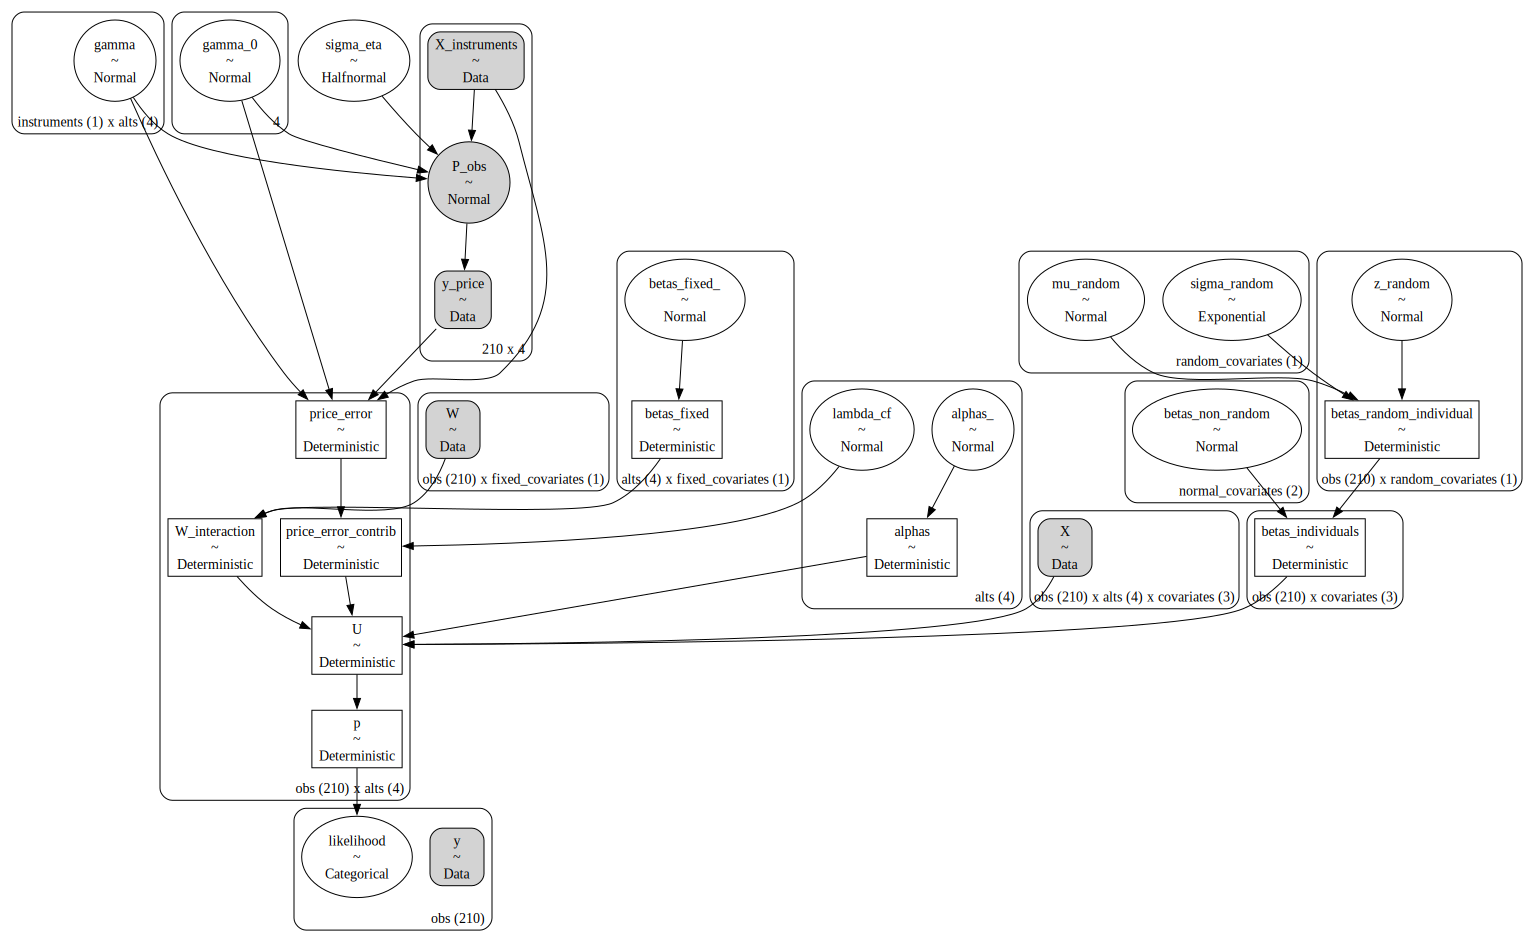

In [12]:
model_unobserved = mxl_1.make_model(mxl.X, mxl.F, mxl.y, observed=False)

pm.model_to_graphviz(model_unobserved)

Now we forward sample from the model to obtain synthetic choices under the new regime. 

In [13]:
p_obs_samples = np.random.normal(size=(df.shape[0], 4))
alphas_ = mxl.idata["posterior"]["alphas_"].mean(dim=["chain", "draw"])
z_random_ = mxl.idata["posterior"]["z_random"].mean(dim=["chain", "draw"])

# Generating data from model by fixing parameters
fixed_parameters = {
    "alphas_": alphas_.values,
    "gamma": np.array([[0.5, 0.5382352, 0.51, 0.5]]),
    "gamma_0": [1.4, 5.9, 3.2, 0.1],
    "lambda_cf": [0.3, 0.3, 0.3, 0.3],
    "mu_random": np.array([-0.5]),
    "sigma_random": np.array([0.1]),
    "sigma_eta": 1.0,
    "betas_non_random": np.array([-0.8, 0.4]),
    "z_random": z_random_.values,
    "P_obs": p_obs_samples,
}
with pm.do(model_unobserved, fixed_parameters) as synthetic_model:
    idata = pm.sample_prior_predictive(
        random_seed=1000,
    )  # Sample from prior predictive distribution.
    synthetic_y = idata["prior"]["likelihood"].sel(draw=0, chain=0)

Sampling: [betas_fixed_, likelihood]


With the synthetic choices generated under the new regime, we can now analyze how the inclusion of the control function for endogeneity affects the estimated market shares compared to the original mixed logit model without endogeneity correction. What we're aiming to see is how the price instrument allows us to disentangle true preference heterogeneity from spurious variation driven by endogenous pricing. 

In [14]:
# Infer parameters conditioned on observed data
with pm.observe(model_unobserved, {"likelihood": synthetic_y}) as inference_model:
    idata_fixed = pm.sample_prior_predictive()
    idata_fixed.extend(
        pm.sample(
            random_seed=100, nuts_sampler="numpyro", chains=4, draws=1000, tune=2000
        )
    )

Sampling: [P_obs, alphas_, betas_fixed_, betas_non_random, gamma, gamma_0, lambda_cf, likelihood, mu_random, sigma_eta, sigma_random, z_random]


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Again, the model samples well and the parameters seem well identified. 

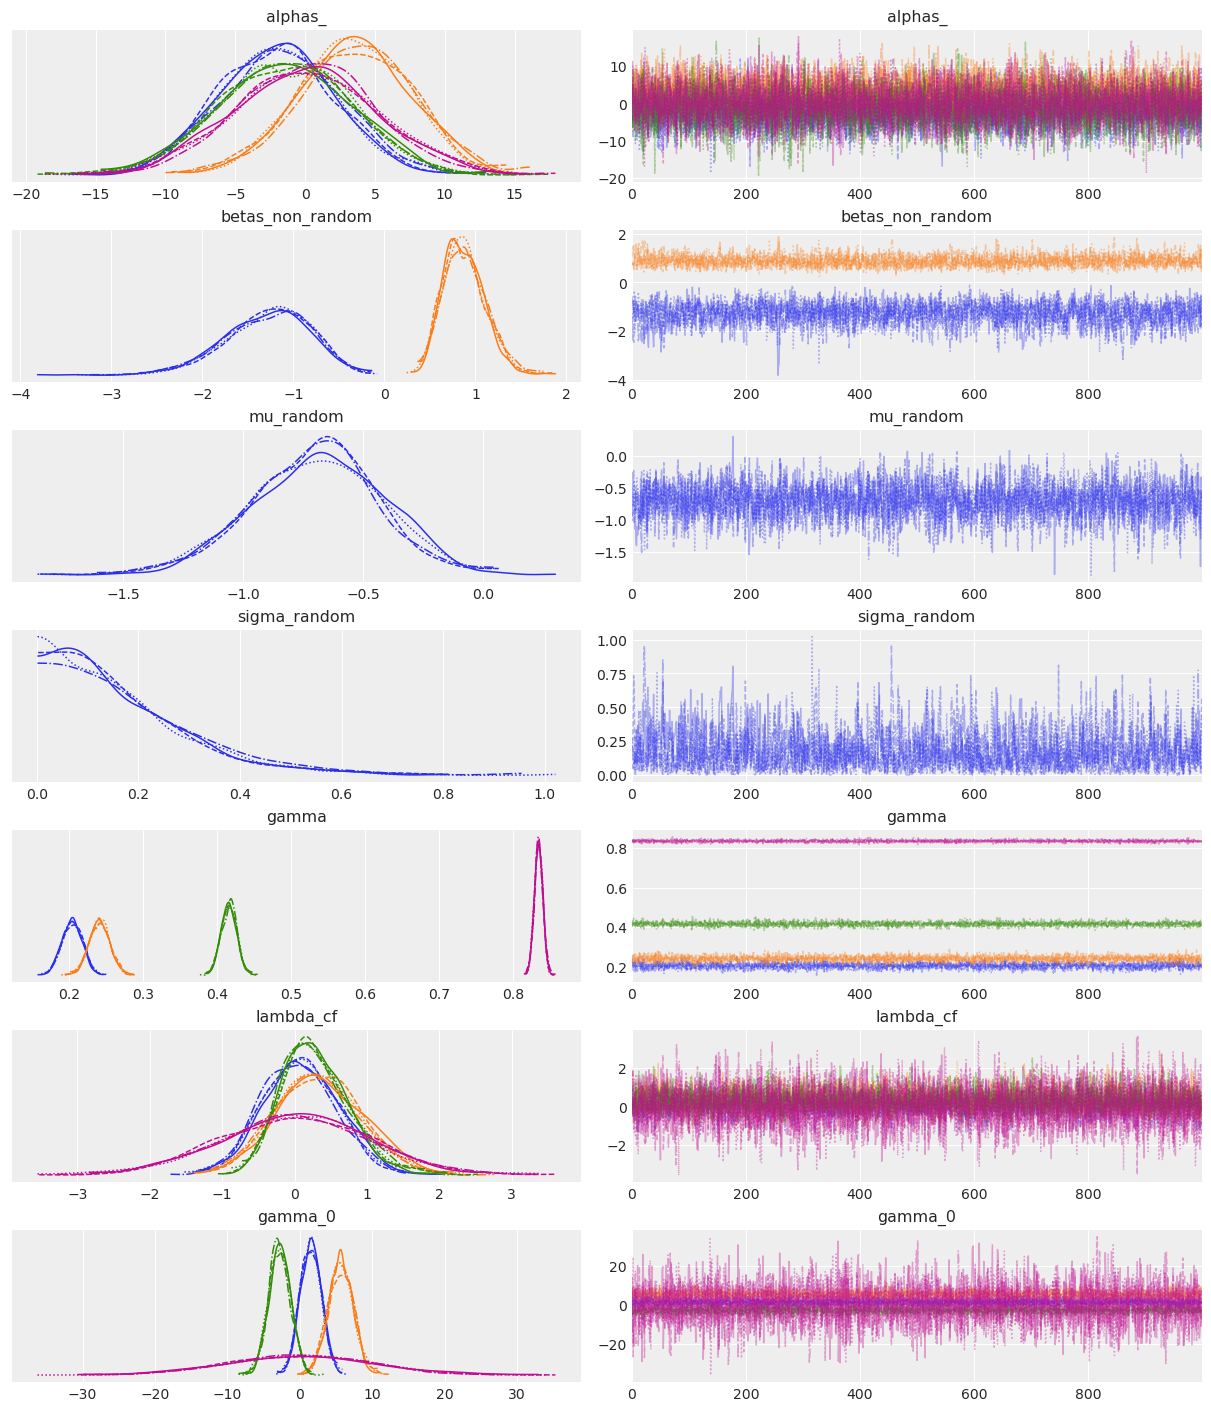

In [15]:
az.plot_trace(
    idata_fixed,
    var_names=[
        "alphas_",
        "betas_non_random",
        "mu_random",
        "sigma_random",
        "gamma",
        "lambda_cf",
        "gamma_0",
    ],
);

However, we can also see how accurately the model recovers the true parameters used to generate the synthetic data. And while the estimates are close, there are some deviations likely due to sampling variability and the complexity of disentangling preference heterogeneity from endogeneity effects. A larger sample size or stronger instruments could help improve recovery of the true parameters.

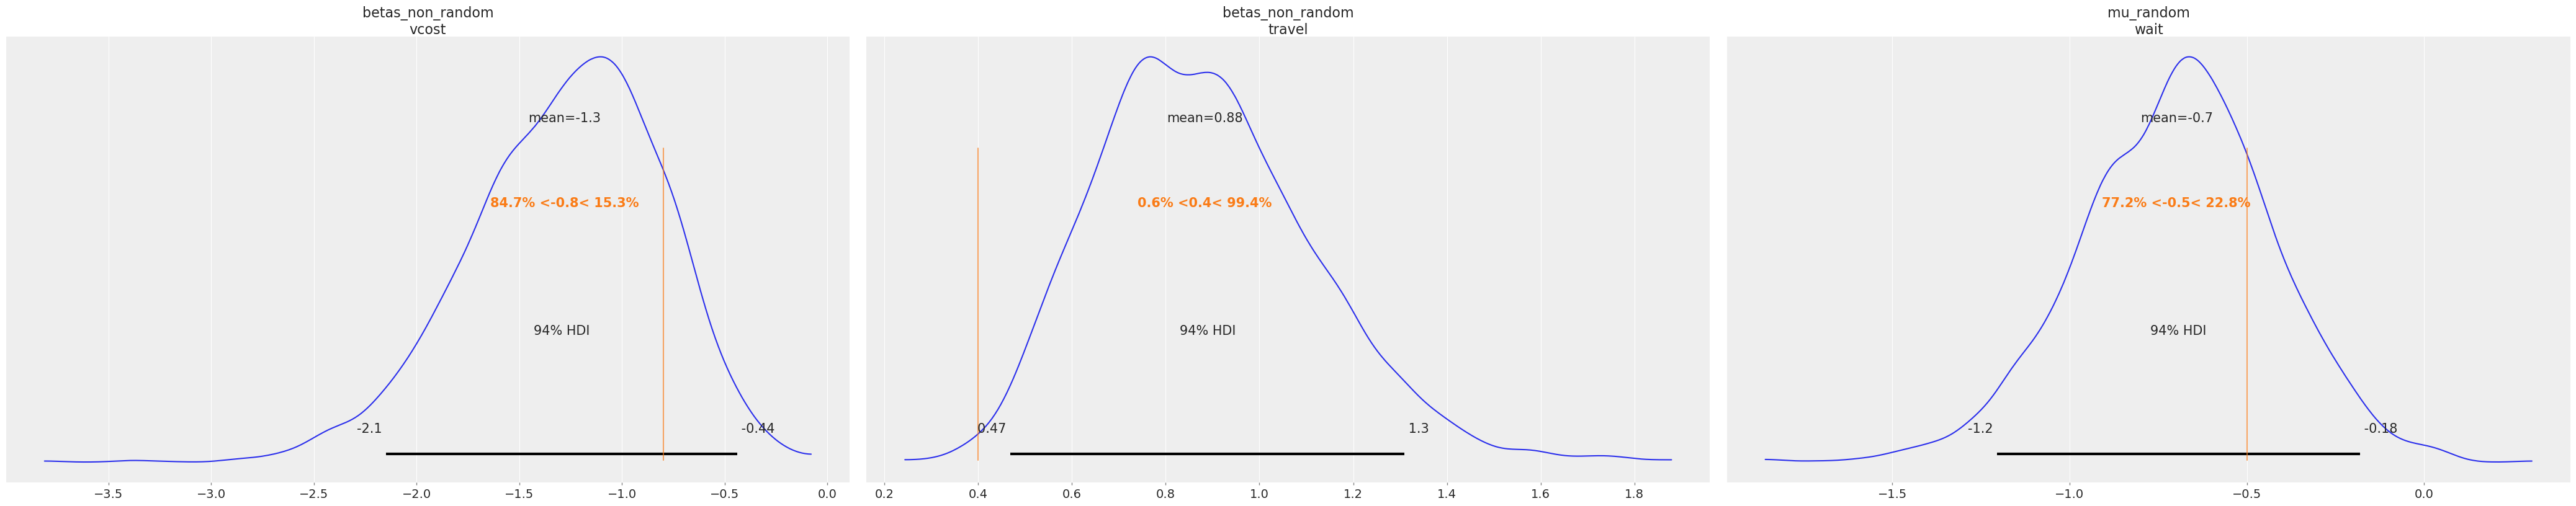

In [16]:
az.plot_posterior(
    idata_fixed,
    var_names=["betas_non_random", "mu_random"],
    ref_val=list(fixed_parameters["betas_non_random"])
    + list(fixed_parameters["mu_random"]),
);

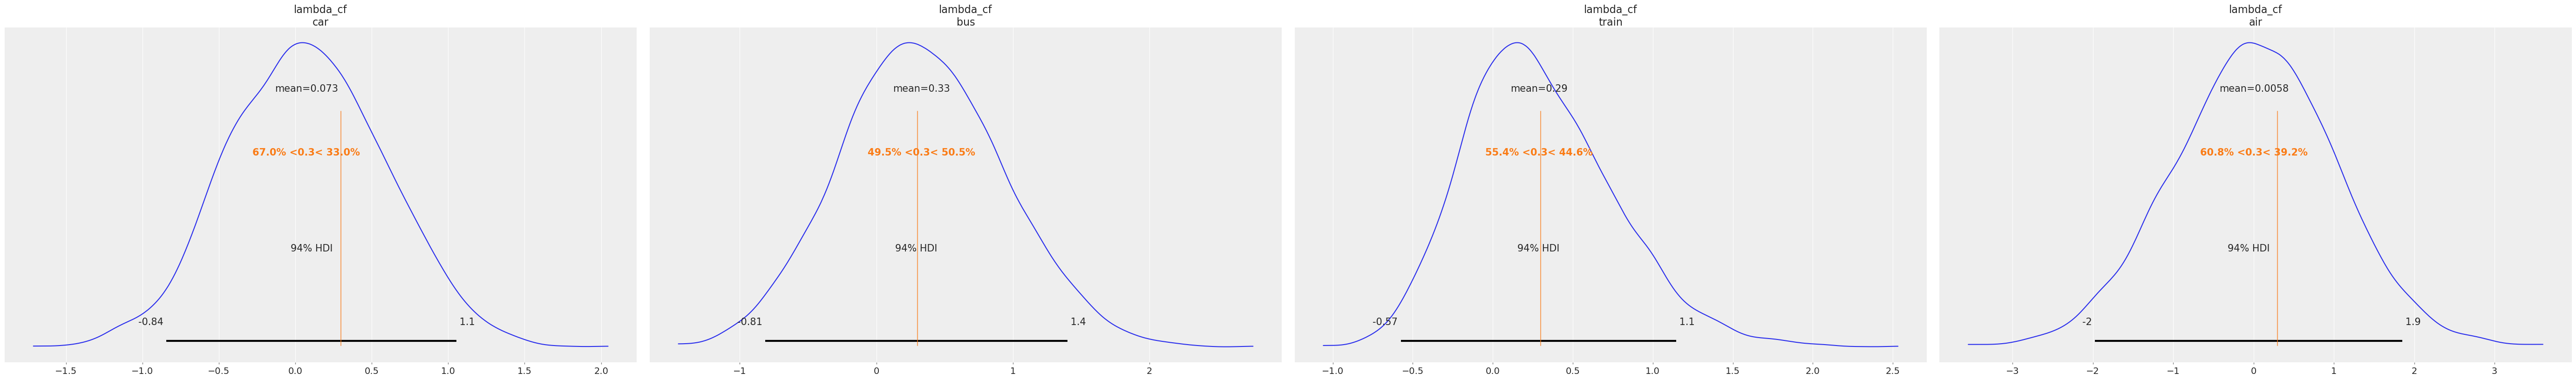

In [17]:
az.plot_posterior(
    idata_fixed,
    var_names=["lambda_cf"],
    ref_val=list(fixed_parameters["lambda_cf"]),
);

## Panel Data and Preference Stability

Let's now extend the mixed logit model to handle panel data, where individuals make multiple choices over time. This allows us to capture preference stability and dynamics across repeated choice occasions.


In [18]:
data_path = data_dir / "choice_crackers.csv"
df_new = pd.read_csv(data_path)
last_chosen = pd.get_dummies(df_new["lastChoice"]).drop("private", axis=1).astype(int)
last_chosen.columns = [col + "_last_chosen" for col in last_chosen.columns]
df_new[last_chosen.columns] = last_chosen
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3156 entries, 0 to 3155
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   personId              3156 non-null   int64  
 1   disp_sunshine         3156 non-null   int64  
 2   disp_keebler          3156 non-null   int64  
 3   disp_nabisco          3156 non-null   int64  
 4   disp_private          3156 non-null   int64  
 5   feat_sunshine         3156 non-null   int64  
 6   feat_keebler          3156 non-null   int64  
 7   feat_nabisco          3156 non-null   int64  
 8   feat_private          3156 non-null   int64  
 9   price_sunshine        3156 non-null   float64
 10  price_keebler         3156 non-null   float64
 11  price_nabisco         3156 non-null   float64
 12  price_private         3156 non-null   float64
 13  choice                3156 non-null   object 
 14  lastChoice            3156 non-null   object 
 15  personChoiceId       

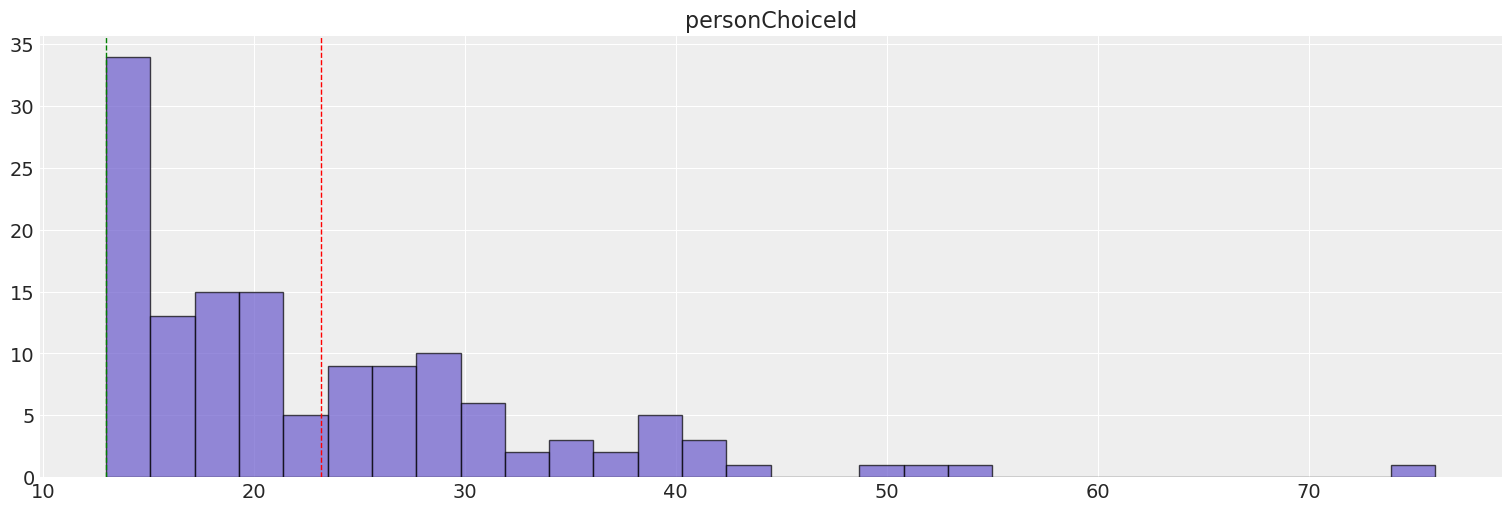

In [19]:
count_choices = df_new.groupby("personId").agg({"personChoiceId": "count"})
ax = count_choices.hist(
    bins=30, figsize=(15, 5), color="slateblue", alpha=0.7, ec="black"
)
ax[0][0].axvline(
    count_choices["personChoiceId"].mean(),
    color="red",
    linestyle="dashed",
    linewidth=1,
    label="Mean",
)
ax[0][0].axvline(
    count_choices["personChoiceId"].min(),
    color="green",
    linestyle="dashed",
    linewidth=1,
    label="Min",
);

#### Train and Test Split for Panel Data
We can split the panel data into training and testing sets while ensuring that all choice occasions for a given individual are contained within either the training or testing set. In this way, we can evaluate the model's predictive performance on unseen individuals while preserving the integrity of the panel structure and assessing preference stability.

In [20]:
utility_formulas = [
    "sunshine ~ disp_sunshine + feat_sunshine + price_sunshine | | price_sunshine ",
    "keebler ~ disp_keebler + feat_keebler + price_keebler | | price_keebler ",
    "nabisco ~ disp_nabisco + feat_nabisco + price_nabisco | | price_nabisco  ",
    "private ~ disp_private + feat_private + price_private | | price_private ",
]

train_df = df_new[df_new["personChoiceId"] <= 5]
test_df = df_new[df_new["personChoiceId"] > 5]

mxl_panel_train = MixedLogit(
    train_df,
    utility_formulas,
    depvar="choice",
    covariates=["disp", "feat", "price"],
    group_id="personId",
)

mxl_panel_test = MixedLogit(
    test_df,
    utility_formulas,
    depvar="choice",
    covariates=["disp", "feat", "price"],
    group_id="personId",
)

We will now train both models. 

In [21]:
mxl_panel_train.sample(
    fit_kwargs={
        "target_accept": 0.95,
        "tune": 2000,
        "draws": 1000,
        "chains": 4,
        "cores": 4,
        "nuts_sampler": "numpyro",
    }
)

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.12/site-packages/pymc_marketing/customer_choice/mixed_logit.py:408: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["alt_encoded"] = df[depvar].map(alt_mapping)
Sampling: [alphas_, betas_non_random, likelihood, mu_random, sigma_random, z_random_group]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [likelihood]


Output()

In [22]:
mxl_panel_test.sample(
    fit_kwargs={
        "target_accept": 0.95,
        "tune": 2000,
        "draws": 1000,
        "chains": 4,
        "cores": 4,
        "nuts_sampler": "numpyro",
    }
)

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.12/site-packages/pymc_marketing/customer_choice/mixed_logit.py:408: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["alt_encoded"] = df[depvar].map(alt_mapping)
Sampling: [alphas_, betas_non_random, likelihood, mu_random, sigma_random, z_random_group]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [likelihood]


Output()

### The Model Structure

We have added multiple observations per individual in the data. This is reflected in the model graph, but we retain only one random effect term on the price coefficient per individual i.e we say that the individual preference is such that it is stable across time. 

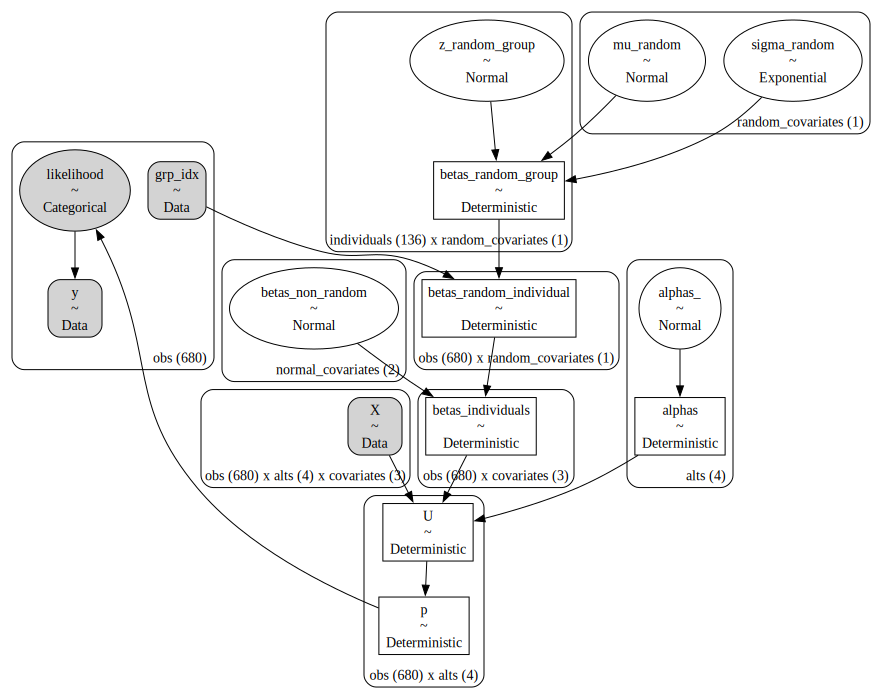

In [23]:
pm.model_to_graphviz(mxl_panel_train.model)

We can observe a broad stability in the model inferred parameters across the train and test splits.

In [24]:
train_inference = az.summary(
    mxl_panel_train.idata,
    var_names=["alphas_", "betas_non_random", "mu_random", "sigma_random"],
)
test_inference = az.summary(
    mxl_panel_test.idata,
    var_names=["alphas_", "betas_non_random", "mu_random", "sigma_random"],
)
pd.concat({"train_parameters": train_inference, "test_parameters": test_inference})

mean     sd  hdi_3%  hdi_97%  \
train_parameters alphas_[sunshine]      -0.491  0.198  -0.861   -0.126   
                 alphas_[keebler]       -0.390  0.250  -0.847    0.082   
                 alphas_[nabisco]        1.560  0.207   1.174    1.942   
                 alphas_[private]        0.019  5.054  -9.679    9.291   
                 betas_non_random[disp]  0.359  0.163   0.059    0.674   
                 betas_non_random[feat]  0.700  0.243   0.256    1.163   
                 mu_random[price]       -0.729  0.432  -1.540    0.073   
                 sigma_random[price]     6.326  0.657   5.086    7.546   
test_parameters  alphas_[sunshine]      -0.552  0.123  -0.787   -0.324   
                 alphas_[keebler]       -0.529  0.161  -0.833   -0.233   
                 alphas_[nabisco]        1.720  0.131   1.470    1.958   
                 alphas_[private]       -0.017  4.854  -9.101    9.057   
                 betas_non_random[disp]  0.305  0.088   0.136    0.470   
                 betas_non_random[feat]  0.673  0.135   0.434    0.942   
                 mu_random[price]       -0.690  0.389  -1.429    0.024   
                 sigma_random[price]     6.173  0.482   5.247    7.041   

                                         mcse_mean  mcse_sd  ess_bulk  \
train_parameters alphas_[sunshine]           0.004    0.003    3173.0   
                 alphas_[keebler]            0.005    0.003    2505.0   
                 alphas_[nabisco]            0.004    0.003    2350.0   
                 alphas_[private]            0.053    0.099    8994.0   
                 betas_non_random[disp]      0.002    0.003    4519.0   
                 betas_non_random[feat]      0.003    0.004    6179.0   
                 mu_random[price]            0.007    0.006    4260.0   
                 sigma_random[price]         0.016    0.009    1778.0   
test_parameters  alphas_[sunshine]           0.002    0.002    2889.0   
                 alphas_[keebler]            0.003    0.002    2316.0   
                 alphas_[nabisco]            0.003    0.002    2160.0   
                 alphas_[private]            0.055    0.086    7779.0   
                 betas_non_random[disp]      0.001    0.002    5719.0   
                 betas_non_random[feat]      0.002    0.002    6235.0   
                 mu_random[price]            0.010    0.005    1401.0   
                 sigma_random[price]         0.014    0.007    1103.0   

                                         ess_tail  r_hat  
train_parameters alphas_[sunshine]         3405.0    1.0  
                 alphas_[keebler]          3220.0    1.0  
                 alphas_[nabisco]          2620.0    1.0  
                 alphas_[private]          2418.0    1.0  
                 betas_non_random[disp]    2977.0    1.0  
                 betas_non_random[feat]    3298.0    1.0  
                 mu_random[price]          3214.0    1.0  
                 sigma_random[price]       2708.0    1.0  
test_parameters  alphas_[sunshine]         3331.0    1.0  
                 alphas_[keebler]          2995.0    1.0  
                 alphas_[nabisco]          2921.0    1.0  
                 alphas_[private]          3098.0    1.0  
                 betas_non_random[disp]    3084.0    1.0  
                 betas_non_random[feat]    3414.0    1.0  
                 mu_random[price]          2379.0    1.0  
                 sigma_random[price]       1885.0    1.0

The same information is probably better reflected in a graph, and we can see how the reference alternative parameters remain unidentified. This is a reminder that discrete choice models estimate relative utility over the baseline `private` choice. 

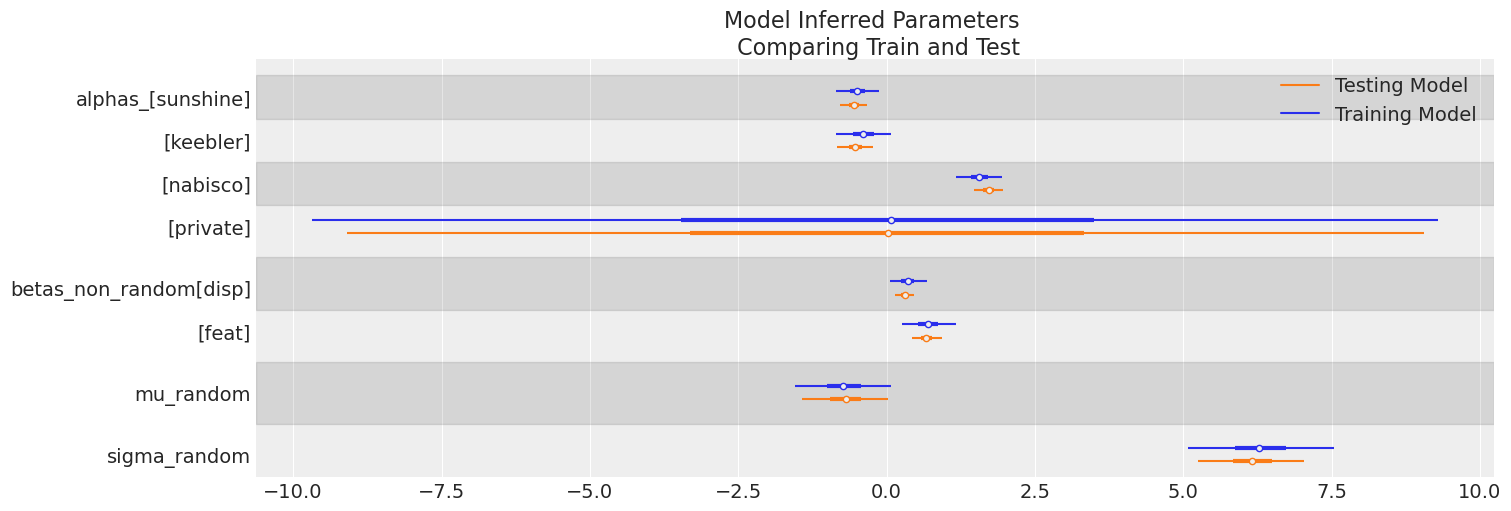

In [25]:
ax = az.plot_forest(
    [mxl_panel_train.idata, mxl_panel_test.idata],
    var_names=["alphas_", "betas_non_random", "mu_random", "sigma_random"],
    combined=True,
    model_names=["Training Model", "Testing Model"],
    figsize=(15, 5),
)
ax[0].set_title("Model Inferred Parameters \n Comparing Train and Test");

But the real test is whether we can use what we learned about the preference ordering from the consumer's first five observed choices to predict the market share determined by their subsequent choices. To do this we take our trained model and update the data with the test inputs. We then sample the posterior predictive distribution and evaluate the accuracy of the forecast market share using a posterior predictive check. 

In [26]:
with mxl_panel_train.model:
    pm.set_data(
        {
            "X": mxl_panel_test.X,
            "y": mxl_panel_test.y,
            "grp_idx": mxl_panel_test.grp_idx,
        },
        coords=mxl_panel_test.coords,
    )
    idata_predict = pm.sample_posterior_predictive(mxl_panel_train.idata)

Sampling: [likelihood]


Output()

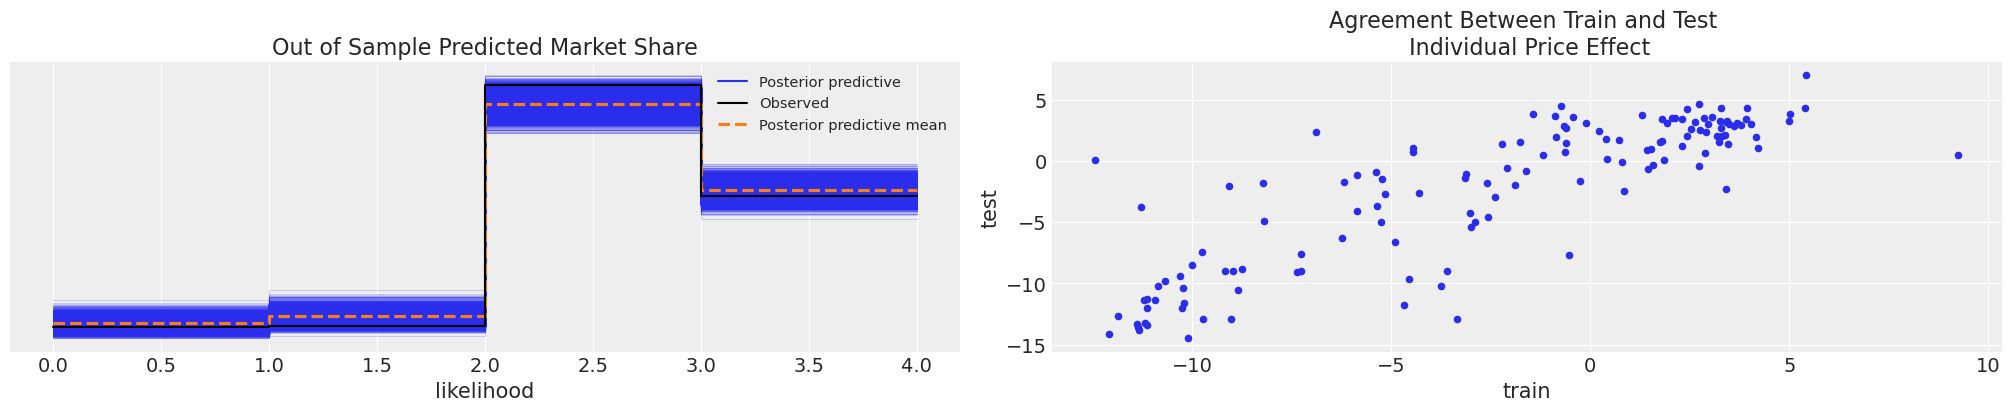

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4))
axs = axs.flatten()
ax = az.plot_ppc(idata_predict, ax=axs[0])
axs[0].set_title("Out of Sample Predicted Market Share")
train_pref = (
    az.summary(mxl_panel_train.idata, var_names=["betas_random_group"])["mean"]
    + az.summary(mxl_panel_train.idata, var_names=["mu_random"])["mean"].item()
)
test_pref = (
    az.summary(mxl_panel_test.idata, var_names=["betas_random_group"])["mean"]
    + az.summary(mxl_panel_test.idata, var_names=["mu_random"])["mean"].item()
)

merged_df = pd.concat([train_pref, test_pref], axis=1)
merged_df.columns = ["train", "test"]
merged_df.plot(x="train", y="test", kind="scatter", ax=axs[1])
axs[1].set_title("Agreement Between Train and Test \n Individual Price Effect");

These plots confirm a kind of robustness to the individual taste profiles that allow for effect out of sample predictions.

### Panel Data and Robust Counterfactuals: How Robust?

As we've seen panel data can play a central role in validating discrete choice models, particularly mixed logit specifications that posit stable, individual-level preference heterogeneity. By observing the same decision-makers across multiple choice occasions, panel data allow the model to distinguish persistent preference orderings from transitory noise. This structure enables out-of-sample prediction at the individual level, providing a meaningful check on whether estimated preferences generalize beyond the estimation sample. When a mixed logit model successfully predicts future choices for the same individuals under new choice situations, it lends credibility to the interpretation that the estimated heterogeneity reflects stable behavioral traits rather than overfitting or incidental correlations.

At the same time, it is important to recognize the limits of what such validation can establish. Strong out-of-sample performance confirms the model’s ability to capture behavioral regularities, but it does not guarantee that the resulting counterfactuals are causally robust. In particular, when market conditions shift in ways that alter the price-setting environment—through policy changes, competitive entry, or supply shocks—the relationship between prices and unobserved attributes may change as well. In such cases, counterfactuals that rely on historically estimated preferences can remain behaviorally coherent yet fail to correspond to the outcomes of feasible market interventions. Panel data strengthen confidence in preference stability, but credible causal counterfactuals still require careful attention to endogeneity and the economic forces that generate prices in the first place. See the work of Train and Petrin in "A Control Function Approach to Endogeneity in Consumer Choice Models" for more details. 

## Conclusion

For these reasons, our implementation combines a mixed logit specification with an explicit control function instrumental variables (IV) approach to price endogeneity. The mixed logit component leverages panel data to recover stable, individual-level preference orderings and to support rich behavioral counterfactuals. The control function component, in turn, disciplines the interpretation of price sensitivity by separating exogenous price variation from variation driven by unobserved market forces. Together, these elements allow the model to support counterfactual analysis that is both behaviorally credible and causally interpretable. In particular, the inclusion of a pricing instrument ensures that heterogeneity in price response reflects genuine differences in preferences rather than distortions arising from endogenous price formation, preserving the validity of counterfactual simulations under policy-relevant price changes. 

In discrete choice contexts we're aiming at modelling two mechanisms that either (a) posit robust individual preference or (b) leverage exogenous shocks to solve the simultaneous equations that govern our system, adjusting for unobserved sources of confounding. Causal inference is hard. We are balancing an array of estimation strategies to find and isolate mechanisms that support robust and reliable counterfactual inference. There is no data derived model which will support inference over arbitrarily distant counterfactual scenarios, so we must always attempt to justify the counterfactual argument our model makes! 

